# 04. K-Nearest Neighbors (KNN)

**Author:** [Your Name/GitHub Username]
**Date:** June 2, 2025

## Introduction

K-Nearest Neighbors (KNN) is a simple, non-parametric, instance-based supervised learning algorithm. It can be used for both classification and regression tasks.

* **Non-parametric:** It doesn't make any assumptions about the underlying data distribution.
* **Instance-based (Lazy Learner):** It doesn't learn a discriminative function from the training data during a "training" phase. Instead, it memorizes the entire training dataset and performs all computations at prediction time.

The core idea is that similar things exist in close proximity. For classification, KNN assigns a class to a new data point based on the majority class of its 'k' closest neighbors in the feature space.

* **Type:** Supervised Learning
* **Task:** Primarily Classification, also Regression
* **Goal:** To classify (or predict a value for) a new data point based on the features of its 'k' nearest neighbors in the training set.

## Theoretical Background

### Key Concepts

1.  **The Algorithm Steps (Classification):**
    * **Store Data:** Memorize all training data points $(X_i, y_i)$.
    * **Calculate Distances:** For a new, unclassified data point $x_q$:
        * Calculate the distance between $x_q$ and every training data point $X_i$. Common distance metrics include:
            * **Euclidean Distance:** $\sqrt{\sum_{j=1}^{d}(x_{qj} - X_{ij})^2}$ (most common)
            * **Manhattan Distance:** $\sum_{j=1}^{d}|x_{qj} - X_{ij}|$
            * **Minkowski Distance:** $(\sum_{j=1}^{d}|x_{qj} - X_{ij}|^p)^{1/p}$ (Euclidean is Minkowski with p=2, Manhattan with p=1)
    * **Identify Neighbors:** Select the 'k' training data points that are closest to $x_q$.
    * **Vote for Class:** Assign the class to $x_q$ that is most frequent among its 'k' nearest neighbors (majority vote).
        * Optionally, votes can be weighted by the inverse of their distance (closer neighbors get a stronger vote).

2.  **'k' - The Number of Neighbors:**
    * This is a crucial hyperparameter that needs to be chosen carefully.
    * **Small 'k' (e.g., k=1):** The model is very flexible and can capture fine-grained patterns, but it's highly sensitive to noise and outliers, leading to high variance and potentially overfitting. The decision boundary can be very complex.
    * **Large 'k':** The model is smoother and less sensitive to noise, leading to lower variance but potentially higher bias (oversimplification). The decision boundary becomes simpler.
    * An odd value for 'k' is often chosen for binary classification to avoid ties.

3.  **Decision Boundary:**
    * KNN can produce complex, non-linear decision boundaries. The shape of the boundary depends on 'k' and the distribution of the data.

4.  **Feature Scaling:**
    * KNN is highly sensitive to the scale of features. Features with larger ranges can dominate the distance calculation. Therefore, **feature scaling (e.g., Standardization or Normalization) is crucial** before applying KNN.

5.  **Curse of Dimensionality:**
    * KNN performance can degrade in high-dimensional spaces (many features). As dimensionality increases, data points tend to become sparse, and the concept of "nearest" becomes less meaningful because distances between points can become more uniform.

6.  **KNN for Regression:**
    * Instead of a majority vote, the prediction for a new data point is typically the **average (or median) of the target values** of its 'k' nearest neighbors.

### Pros
* Simple to understand and implement.
* No explicit training phase (lazy learner).
* Naturally handles multi-class classification.
* Can create complex decision boundaries (non-linear).
* Effective if features are well-scaled and relevant.

### Cons
* Computationally expensive at prediction time, especially with large datasets, as it needs to compute distances to all training points.
* Requires careful feature scaling.
* Performance degrades with high dimensionality (curse of dimensionality).
* Sensitive to irrelevant features (as they can influence distance calculations).
* Choosing the optimal 'k' can be challenging.
* Needs a good way to handle missing data (or impute it).

### Common Use Cases
* Recommendation systems.
* Anomaly detection.
* Concept search (finding similar documents or images).
* Gene expression analysis.
* Simple baseline for classification tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap # For decision boundary plotting

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import metrics # For accuracy, confusion matrix, classification report

# Set a style for seaborn plots
sns.set_style('whitegrid')

## Implementation with Python (Classification)

We'll use the **Iris dataset** from Scikit-learn for this classification example. We will select two features for easier visualization of the decision boundary.

In [2]:
from sklearn.datasets import load_iris

# Load the dataset
iris = load_iris()

# For visualization, let's use only the first two features (sepal length and sepal width)
# and all three classes.
X = iris.data[:, :2]
y = iris.target

# Create a Pandas DataFrame for features and a Series for the target (optional, for inspection)
X_df = pd.DataFrame(X, columns=iris.feature_names[:2])
y_s = pd.Series(y, name='Target_Class')
target_names = iris.target_names

print("Features (X) - First 5 rows (Sepal Length & Width):")
print(X_df.head())
print(f"\nShape of selected features: {X_df.shape}")

print("\nTarget (y) - Class distribution:")
print(y_s.value_counts().sort_index())
print(f"Target names: {target_names}") # 0: setosa, 1: versicolor, 2: virginica

Features (X) - First 5 rows (Sepal Length & Width):
   sepal length (cm)  sepal width (cm)
0                5.1               3.5
1                4.9               3.0
2                4.7               3.2
3                4.6               3.1
4                5.0               3.6

Shape of selected features: (150, 2)

Target (y) - Class distribution:
Target_Class
0    50
1    50
2    50
Name: count, dtype: int64
Target names: ['setosa' 'versicolor' 'virginica']


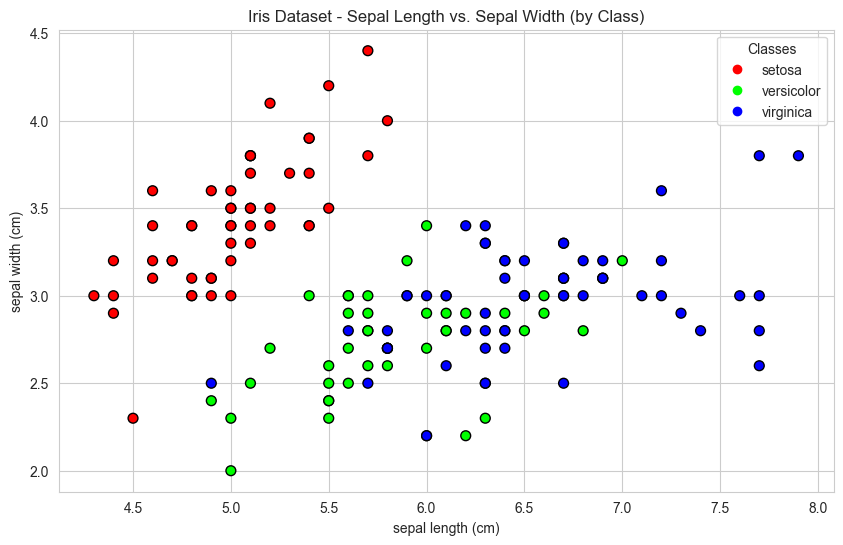

In [3]:
# Visualize the data using the two selected features
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_df.iloc[:, 0], X_df.iloc[:, 1], c=y_s, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']), edgecolor='k', s=50)
plt.title('Iris Dataset - Sepal Length vs. Sepal Width (by Class)')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Classes")
plt.show()

The scatter plot shows the distribution of the three Iris species based on sepal length and sepal width. Setosa (class 0) appears quite separable, while versicolor (class 1) and virginica (class 2) have some overlap.

In [4]:
# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_s, test_size=0.3, random_state=42, stratify=y_s)

print(f"Training set size: X_train: {X_train.shape[0]}, y_train: {y_train.shape[0]}")
print(f"Testing set size: X_test: {X_test.shape[0]}, y_test: {y_test.shape[0]}")

# 2. Feature Scaling (CRUCIAL for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Only transform on test set

# Convert scaled arrays back to DataFrames (optional, for inspection)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_df.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_df.columns)

print("\nFirst 5 rows of scaled training data:")
print(X_train_scaled_df.head())

Training set size: X_train: 105, y_train: 105
Testing set size: X_test: 45, y_test: 45

First 5 rows of scaled training data:
   sepal length (cm)  sepal width (cm)
0          -0.900459         -1.220248
1           0.380366         -1.879558
2          -0.900459          1.636764
3           1.078998          0.318143
4          -0.201827         -0.560937


In [5]:
# Choose a value for k (number of neighbors)
k_value = 5 # We'll explore how to choose k later

# Create a KNN classifier instance
# common distance metric is 'minkowski' with p=2 (Euclidean)
knn_classifier = KNeighborsClassifier(n_neighbors=k_value, metric='minkowski', p=2)

# "Fit" the model (KNN just stores the training data)
knn_classifier.fit(X_train_scaled, y_train)

print(f"KNN Classifier (k={k_value}) instantiated and 'trained'.")

KNN Classifier (k=5) instantiated and 'trained'.


In [6]:
# Make predictions on the scaled test set
y_pred_class = knn_classifier.predict(X_test_scaled)

# Display some predictions
predictions_df = pd.DataFrame({
    'Actual Target': y_test.values,
    'Predicted Class': y_pred_class
})
print("\nActual vs Predicted classes (first 10):")
print(predictions_df.head(10))


Actual vs Predicted classes (first 10):
   Actual Target  Predicted Class
0              2                2
1              1                1
2              2                2
3              1                2
4              2                1
5              2                1
6              1                1
7              1                1
8              0                0
9              2                1


### Model Evaluation Metrics (Classification)


Accuracy (k=5): 0.7333


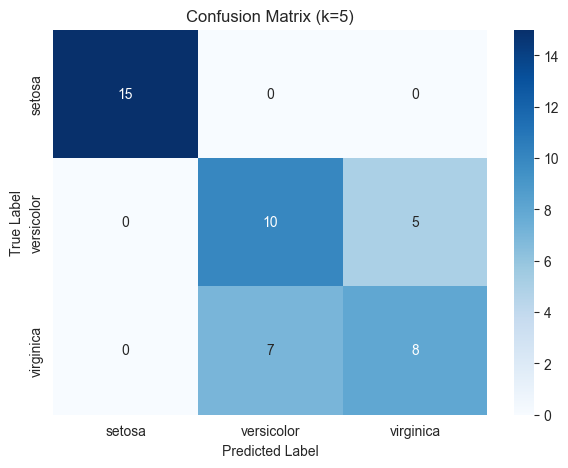


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.59      0.67      0.62        15
   virginica       0.62      0.53      0.57        15

    accuracy                           0.73        45
   macro avg       0.73      0.73      0.73        45
weighted avg       0.73      0.73      0.73        45



In [7]:
# 1. Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(f"\nAccuracy (k={k_value}): {accuracy:.4f}")

# 2. Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (k={k_value})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Classification Report
class_report = metrics.classification_report(y_test, y_pred_class, target_names=target_names)
print("\nClassification Report:")
print(class_report)

### Visualizing Decision Boundaries (for 2 features)
This helps understand how KNN partitions the feature space.

/opt/anaconda3/envs/ml_explorer/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


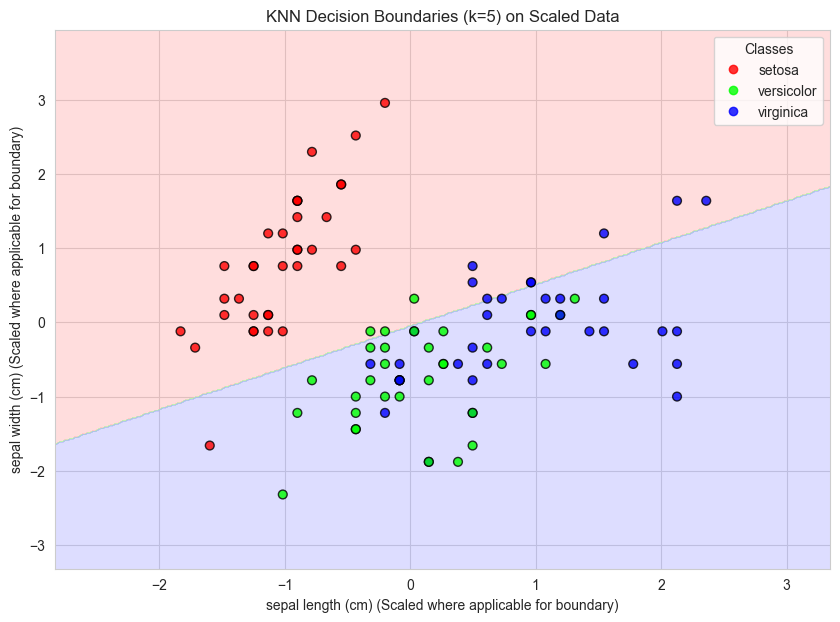

In [8]:
def plot_decision_boundaries(X, y, model, scaler, feature_names, target_names_list, k_val):
    # Create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Scale the mesh points before prediction
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_scaled = scaler.transform(mesh_points) # Use the SAME scaler fitted on training data
    
    Z = model.predict(mesh_points_scaled)
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    plt.figure(figsize=(10, 7))
    custom_cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']) # Light Red, Green, Blue
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap)

    # Plot training points (or test points)
    scatter_plot = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']), edgecolor='k', s=40, alpha=0.8)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'KNN Decision Boundaries (k={k_val}) on Scaled Data')
    plt.xlabel(feature_names[0] + " (Scaled where applicable for boundary)")
    plt.ylabel(feature_names[1] + " (Scaled where applicable for boundary)")
    plt.legend(handles=scatter_plot.legend_elements()[0], labels=list(target_names_list), title="Classes")
    plt.show()

# We need to use the SCALED training data for fitting the model used for decision boundary plot
# to ensure consistency, then plot on the original scale or indicate scaled axis.
# For this visualization, let's use the original training data features (unscaled) to show the points
# but understand the model for boundary was trained on scaled data.

# Re-fit a model on the FULL training set (X_train_scaled) if you want to show boundaries based on all training.
# Or, use the X_test_scaled and y_test to visualize on test data.
# Let's visualize based on the training data points:
# For plotting points, use unscaled X_train, but the decision boundary is derived from scaled data.
plot_decision_boundaries(X_train_scaled, y_train, knn_classifier, scaler, iris.feature_names, target_names, k_value)

## Choosing the Optimal 'k'

The choice of 'k' significantly impacts the KNN model. A common way to find a good 'k' is to try different values and see which one yields the best performance (e.g., highest accuracy or lowest error rate) on a validation set or using cross-validation.

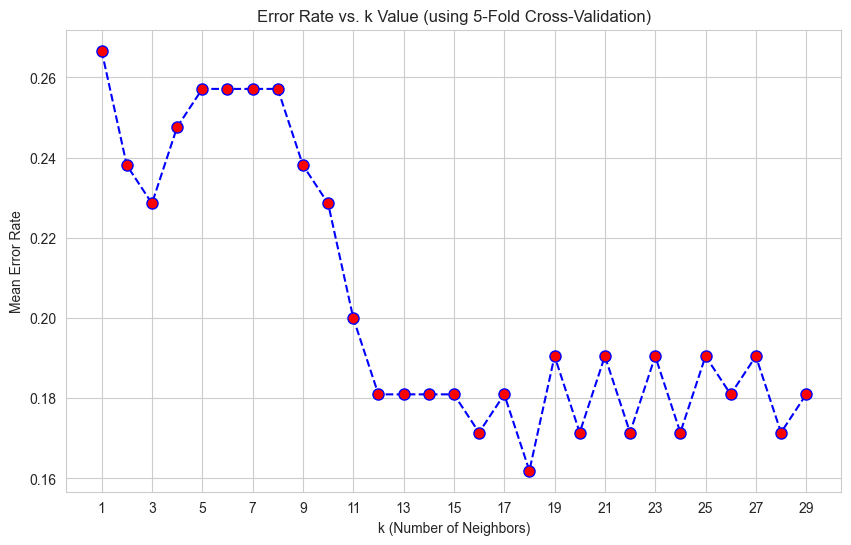


Optimal k based on minimum cross-validated error rate: 18
Minimum error rate: 0.1619


In [9]:
error_rate = []
k_range = range(1, 30) # Test k values from 1 to 29

for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    # Using cross-validation to get a more robust error estimate
    # Here, accuracy is used. Error rate = 1 - accuracy.
    # Note: cross_val_score uses a new clone of the estimator for each fold.
    # The data X_train_scaled and y_train are split multiple times.
    scores = cross_val_score(knn_temp, X_train_scaled, y_train, cv=5, scoring='accuracy') # 5-fold CV
    error_rate.append(1 - scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. k Value (using 5-Fold Cross-Validation)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Error Rate')
plt.xticks(np.arange(min(k_range), max(k_range)+1, 2.0))
plt.grid(True)
plt.show()

# Find the k with the minimum error rate
optimal_k_index = np.argmin(error_rate)
optimal_k = k_range[optimal_k_index]
print(f"\nOptimal k based on minimum cross-validated error rate: {optimal_k}")
print(f"Minimum error rate: {error_rate[optimal_k_index]:.4f}")

# You would then retrain your final model using this optimal k on the full training set.
# For example:
# final_knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k)
# final_knn_classifier.fit(X_train_scaled, y_train)
# y_pred_final = final_knn_classifier.predict(X_test_scaled)
# print(f"Accuracy with optimal k={optimal_k}: {metrics.accuracy_score(y_test, y_pred_final):.4f}")

## KNN for Regression (Brief Example)

KNN can also be used for regression tasks. Instead of predicting a class label, it predicts a continuous value, typically by averaging the target values of its 'k' nearest neighbors.


KNN Regression (k=5) Evaluation:
Mean Squared Error (MSE): 0.2996
R-squared (R²): 0.4505


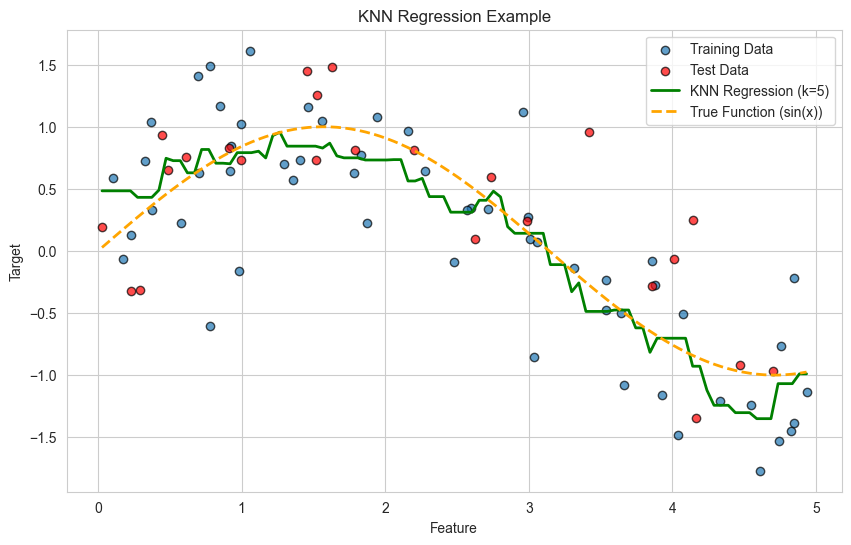

In [10]:
# Generate some simple 1D synthetic data for regression
np.random.seed(42)
X_reg = np.sort(5 * np.random.rand(80, 1), axis=0)
T_reg = np.sin(X_reg).ravel() # True underlying function
y_reg = T_reg + np.random.randn(80) * 0.5 # Add some noise

# Split data (simple split for this demo)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Feature scaling (still important!)
scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

# KNN Regressor
k_reg = 5
knn_regressor = KNeighborsRegressor(n_neighbors=k_reg)
knn_regressor.fit(X_reg_train_scaled, y_reg_train)

# Predictions
y_reg_pred = knn_regressor.predict(X_reg_test_scaled)

# Evaluation
mse_reg = metrics.mean_squared_error(y_reg_test, y_reg_pred)
r2_reg = metrics.r2_score(y_reg_test, y_reg_pred)
print(f"\nKNN Regression (k={k_reg}) Evaluation:")
print(f"Mean Squared Error (MSE): {mse_reg:.4f}")
print(f"R-squared (R²): {r2_reg:.4f}")

# Plotting the results
# Create points for plotting the regression line
X_plot_reg = np.linspace(X_reg.min(), X_reg.max(), 100).reshape(-1, 1)
X_plot_reg_scaled = scaler_reg.transform(X_plot_reg)
y_plot_pred_reg = knn_regressor.predict(X_plot_reg_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_reg_train, y_reg_train, alpha=0.7, edgecolor='k', label='Training Data')
plt.scatter(X_reg_test, y_reg_test, color='red', alpha=0.7, edgecolor='k', label='Test Data')
plt.plot(X_plot_reg, y_plot_pred_reg, color='green', linewidth=2, label=f'KNN Regression (k={k_reg})')
plt.plot(X_plot_reg, np.sin(X_plot_reg), color='orange', linestyle='--', linewidth=2, label='True Function (sin(x))')
plt.title('KNN Regression Example')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

## Conclusion & Key Takeaways

* K-Nearest Neighbors (KNN) is a simple, versatile instance-based learning algorithm for both classification and regression.
* It classifies new points based on the majority vote (or averages target values for regression) of its 'k' closest neighbors.
* **Feature scaling is critical** for KNN due to its reliance on distance metrics.
* The choice of **'k' is a crucial hyperparameter** that affects the model's bias-variance tradeoff. Cross-validation can help find an optimal 'k'.
* KNN can form complex, non-linear decision boundaries.
* It's considered a "lazy learner" as most computation happens at prediction time.
* Its performance can suffer from the curse of dimensionality and irrelevant features.

## Further Reading/References (Optional)

* [Scikit-learn KNeighborsClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [Scikit-learn KNeighborsRegressor Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
* Chapter on KNN in "An Introduction to Statistical Learning" by James, Witten, Hastie, and Tibshirani.
* StatQuest: K-nearest neighbors, Clearly Explained.